# IMPORTS

Por incompatibilidades entre librerias nos vemos obligados a hacer este workaround para que solucionar los problemas de dependencias.

In [42]:
import  scipy.signal.signaltools
import numpy as np

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pytorch_forecasting
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from lightning.pytorch.tuner import Tuner
from  scipy.signal.signaltools import _centered
from tft_helper import get_best_lr, tft_trainer, tft_predict, run_hyperparameter_optimization, save_exp_results


# PARAMS

In [43]:
model_days = 700
# validation_days = 14
# test_days = 15
n_prev_hours = 24*21
group = 'month'
epochs = 30
exp_path = 'TFT_experiments.xlsx'



lr_finder = False
grid_search = False

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


#TFT params
tft_params =  {'gradient_clip_val': 0.05808054277495504, 'hidden_size': 32, 'dropout': 0.2997107370422699, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.017853144294677083}
# tft_params =  {'gradient_clip_val': 0.010584137969017322, 'hidden_size': 36, 'dropout': 0.2960659121982872, 'hidden_continuous_size': 22, 'attention_head_size': 4, 'learning_rate': 0.0010322318420096076}
# tft_params = {'gradient_clip_val': 0.46964879113018865, 'hidden_size': 8, 'dropout': 0.10391553098833228, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.2855372166883186}


hyperparams_grid = {
    "gradient_clip_val_range": (0.01, 1.0),
    "hidden_size_range": (8, 64),
    "hidden_continuous_size_range": (8, 64),
    "attention_head_size_range": (1, 4),
    "learning_rate_range": (0.001, 0.3),
    "dropout_range": (0.1, 0.3),
    "trainer_kwargs": dict(limit_train_batches=60),
    "reduce_on_plateau_patience": 4,
    "use_learning_rate_finder": False
}




# LOAD DATA

In [44]:
# Cargar los datos
file_path =  './datasets/dataset_input_v1.xlsx'

df = pd.read_excel(file_path)

df = df.rename(columns={'EUA': 'co2'})
df['fechaHora'] = pd.to_datetime(df['fechaHora'])

df = df.dropna(subset=['precio_spot'])


Exception ignored in: <function ZipFile.__del__ at 0x000002A53C533820>
Traceback (most recent call last):
  File "c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\zipfile.py", line 1821, in __del__
    self.close()
KeyboardInterrupt: 


In [ ]:
df

,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa
0,2019-01-01 01:00:00,66.88,22781.000000,24.18,24.45,3782.166667,29.166667,19101.300,824.100
1,2019-01-01 02:00:00,66.00,21448.500000,24.18,24.45,3740.333333,23.500000,17924.100,1177.200
2,2019-01-01 03:00:00,63.64,20262.166667,24.18,24.45,3711.500000,14.000000,16725.000,1199.100
3,2019-01-01 04:00:00,58.85,19463.500000,24.18,24.45,3530.000000,14.000000,15826.800,898.200
4,2019-01-01 05:00:00,55.47,19164.000000,24.18,24.45,3390.166667,14.000000,15769.300,57.500
...,...,...,...,...,...,...,...,...,...
46531,2024-04-22 19:00:00,0.45,27209.083000,64.54,30.43,11333.333000,9408.916667,10095.400,-5391.325
46532,2024-04-22 20:00:00,6.00,29248.333000,64.54,30.43,13670.417000,3038.250000,16069.450,-5974.050
46533,2024-04-22 21:00:00,12.81,30731.833000,64.54,30.43,13265.333000,1025.916667,17111.625,-1042.175
46534,2024-04-22 22:00:00,7.62,28432.417000,64.54,30.43,12733.917000,932.833333,14830.575,2281.050


<!-- ## DF FINL -->

In [ ]:
now = pd.Timestamp.now()
last_day = df['fechaHora'].iloc[-1]
# Calcula la fecha hace dos meses utilizando timedelta
fecha_start = (last_day - pd.Timedelta(days=model_days)).replace(hour=0, minute=0, second=0)

# Filtra las filas 
df_last = df[df['fechaHora'] >= fecha_start]
df_last.loc[:,'precio_spot'] = np.where(df_last['precio_spot'] < 0, 0, df_last['precio_spot'])



C:\Users\nvegamun\AppData\Local\Temp\ipykernel_3796\866086546.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last.loc[:,'precio_spot'] = np.where(df_last['precio_spot'] < 0, 0, df_last['precio_spot'])


In [ ]:
df_last

,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa
29710,2022-05-23 00:00:00,197.01,23138.500000,78.18,74.93,7750.500000,59.000000,15086.400,1392.800
29711,2022-05-23 01:00:00,180.18,21706.500000,78.18,74.93,7192.166667,62.666667,14462.800,623.600
29712,2022-05-23 02:00:00,171.55,21003.166667,78.18,74.93,7167.833333,39.666667,13692.300,770.500
29713,2022-05-23 03:00:00,171.54,20700.166667,78.18,74.93,7005.000000,39.166667,13563.200,129.100
29714,2022-05-23 04:00:00,171.49,20753.000000,78.18,74.93,7081.500000,39.000000,13549.300,13.900
...,...,...,...,...,...,...,...,...,...
46531,2024-04-22 19:00:00,0.45,27209.083000,64.54,30.43,11333.333000,9408.916667,10095.400,-5391.325
46532,2024-04-22 20:00:00,6.00,29248.333000,64.54,30.43,13670.417000,3038.250000,16069.450,-5974.050
46533,2024-04-22 21:00:00,12.81,30731.833000,64.54,30.43,13265.333000,1025.916667,17111.625,-1042.175
46534,2024-04-22 22:00:00,7.62,28432.417000,64.54,30.43,12733.917000,932.833333,14830.575,2281.050


## DATA SPLIT

In [ ]:

data = df_last.copy()
data = data.reset_index(drop=True)
data = data.drop_duplicates('fechaHora', keep='last')



In [ ]:
data = data[data['fechaHora'] < '2024-04-21 00:00:00']


In [ ]:


data['month'] = data['fechaHora'].dt.to_period('M').astype(str).astype('category').cat.codes
data['week'] = data['fechaHora'].dt.strftime('%Y-%U').astype(str).astype('category').cat.codes
# data['day'] = data['fechaHora'].dt.day.astype('category').cat.codes

data['day'] = (data['fechaHora'] - data['fechaHora'].min()).dt.days
data['hour'] = data['fechaHora'].dt.hour


data['time_idx'] = data.groupby(group).cumcount() 



In [ ]:
data

,fechaHora,precio_spot,demanda,co2,precio_gas,prod_eolica,prod_solar,demanda_residual,rampa,month,week,day,hour,time_idx
0,2022-05-23 00:00:00,197.01,23138.500000,78.18,74.93,7750.500000,59.000000,15086.400,1392.800,0,0,0,0,0
1,2022-05-23 01:00:00,180.18,21706.500000,78.18,74.93,7192.166667,62.666667,14462.800,623.600,0,0,0,1,1
2,2022-05-23 02:00:00,171.55,21003.166667,78.18,74.93,7167.833333,39.666667,13692.300,770.500,0,0,0,2,2
3,2022-05-23 03:00:00,171.54,20700.166667,78.18,74.93,7005.000000,39.166667,13563.200,129.100,0,0,0,3,3
4,2022-05-23 04:00:00,171.49,20753.000000,78.18,74.93,7081.500000,39.000000,13549.300,13.900,0,0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16773,2024-04-20 19:00:00,3.25,23285.833000,66.94,30.43,9516.833000,6549.166667,9076.925,-4252.825,23,100,698,19,475
16774,2024-04-20 20:00:00,7.88,24815.083000,66.94,30.43,11538.750000,1462.833333,13523.325,-4446.400,23,100,698,20,476
16775,2024-04-20 21:00:00,10.00,26729.000000,66.94,30.43,12262.667000,315.250000,14761.325,-1238.000,23,100,698,21,477
16776,2024-04-20 22:00:00,8.58,25400.167000,66.94,30.43,12260.583000,234.500000,13095.525,1665.800,23,100,698,22,478


## TimeSeriesDataset

In [ ]:

features = [col for col in data.columns if col != 'precio_spot' ]  # Columnas de características and col != 'fechaHora'

max_prediction_length = 24
max_encoder_length = n_prev_hours #48
# training_cutoff = data["fechaHora"].max() - pd.Timedelta(hours=max_encoder_length)
training_cutoff = data["time_idx"].max() - max_prediction_length


train = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="precio_spot",
    group_ids=[group],
   min_encoder_length=24,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    #min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[], # group of categorical variables can be treated as one variable
    time_varying_known_reals=features,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['precio_spot'],
    lags={'precio_spot': [24,48,72]},
    target_normalizer=GroupNormalizer('robust',
        groups=[group],
        transformation="softplus"
    ),
  
   # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    # allow_missing_timesteps=True,
    # add_encoder_length=True,
    categorical_encoders={
        'month':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'week':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'day':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        
    },
)

validation = TimeSeriesDataSet.from_dataset(train, data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = train.to_dataloader(train=True, batch_size=batch_size, num_workers=11, persistent_workers=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)


c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
validation

TimeSeriesDataSet[length=24](
	time_idx='time_idx',
	target='precio_spot',
	group_ids=['month'],
	weight=None,
	max_encoder_length=504,
	min_encoder_length=24,
	min_prediction_idx=0,
	min_prediction_length=24,
	max_prediction_length=24,
	static_categoricals=[],
	static_reals=['encoder_length', 'precio_spot_center', 'precio_spot_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['fechaHora', 'demanda', 'co2', 'precio_gas', 'prod_eolica', 'prod_solar', 'demanda_residual', 'rampa', 'month', 'week', 'day', 'hour', 'time_idx', 'relative_time_idx', 'precio_spot_lagged_by_24', 'precio_spot_lagged_by_48', 'precio_spot_lagged_by_72'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['precio_spot'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={'precio_spot': [24, 48, 72]},
	add_relative_time_idx=True,
	add_target_scales=True,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='robust',
	groups=


# LEARNIG RATE FINDER

En primer lugar realizamos un estudio para hallar de forma aproximada el valor optimo de tasa de aprendizaje.  No es recomendable al 100% usar el valor sugerido directamente pues a veces no encuentra el mejor, sin embargo si que da un muy buen punto de partida por donde empezar a probar. Para ello usamos un modelo TFT cualquiera basico.

In [ ]:
if lr_finder:
    res = get_best_lr(train, train_dataloader, val_dataloader, **tft_params)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 153.1k


c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


AttributeError: 'LearningRateFinder' object has no attribute 'optimal_lr'

# MODELLING

In [ ]:
# use_suggested_lr = input('Use suggested lr??
# if use_suggested_lr:
#     tft_params['learning_rate'] = res
# else:

    

## TRAIN MODEL

In [ ]:
if not grid_search:
    tft_params['learning_rate'] = 0.01 #0.017
    tft, val_loss = tft_trainer(train, train_dataloader, val_dataloader, max_epochs=epochs, save_model=False, **tft_params)
    save_exp_results(exp_path, tft_params, model_days, n_prev_hours, group, val_loss, epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tfg\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: 100%|██████████| 64/64 [03:24<00:00,  0.31it/s, v_num=17, train_loss_step=23.20]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 64/64 [03:26<00:00,  0.31it/s, v_num=17, train_loss_step=11.60, val_loss=25.70, train_loss_epoch=28.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 64/64 [03:32<00:00,  0.30it/s, v_num=17, train_loss_step=11.40, val_loss=15.90, train_loss_epoch=16.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 64/64 [03:32<00:00,  0.30it/s, v_num=17, train_loss_step=9.580, val_loss=11.00, train_loss_epoch=11.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 64/64 [03:33<00:00,  0.30it/s, v_num=17, train_loss_step=8.600, val_loss=8.820, train_loss_epoch=9.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 64/64 [03:27<00:00,  0.31it/s, v_num=17, train_loss_step=6.490, val_loss=7.550, train_loss_epoch=8.050]
Validation: |          | 0/? [

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 64/64 [03:18<00:00,  0.32it/s, v_num=17, train_loss_step=3.780, val_loss=5.350, train_loss_epoch=3.820]
Number of parameters in network: 153.1k


c:\Users\nvegamun\Documents\SPOT-Price-Forecast-NN\src\tft_helper.py:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tft_exps = tft_exps.append(new_exp, ignore_index=True)


### EVAL MODEL

c:\Users\nicov\anaconda3\envs\tfg\lib\site-packages\pytorch_forecasting\models\base_model.py:1016: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


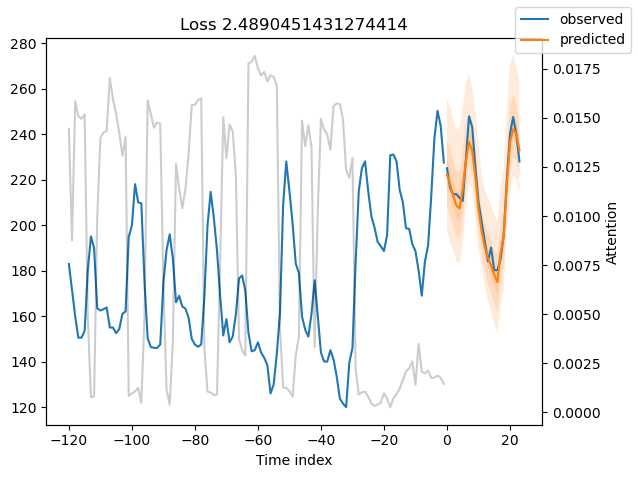

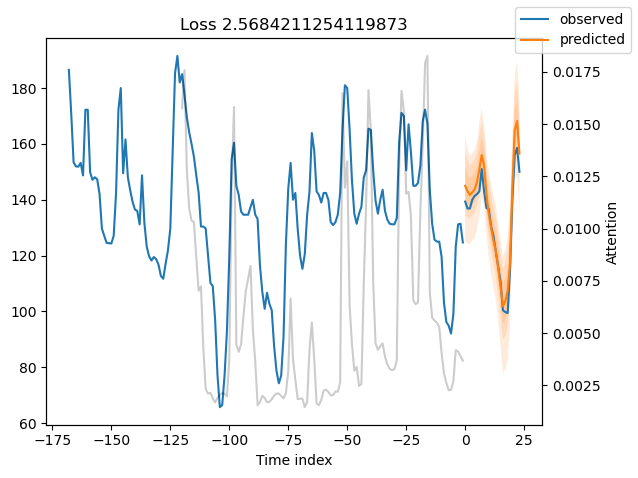

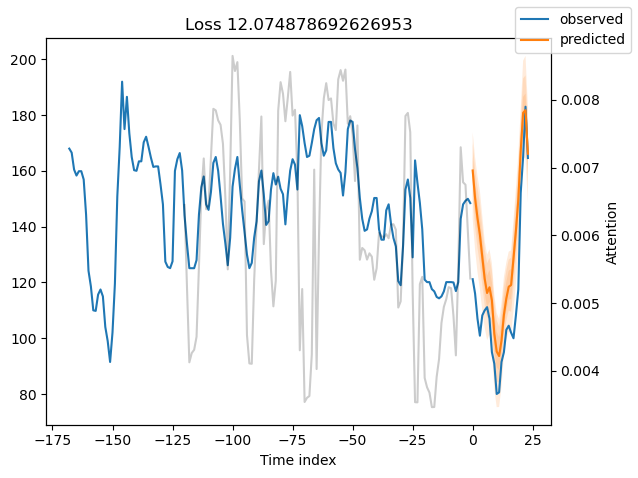

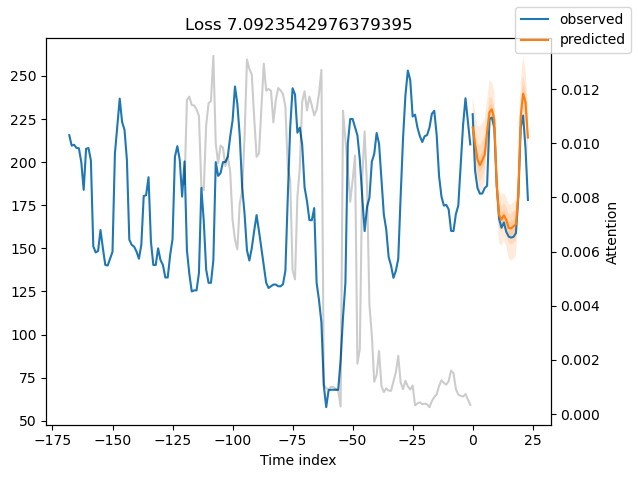

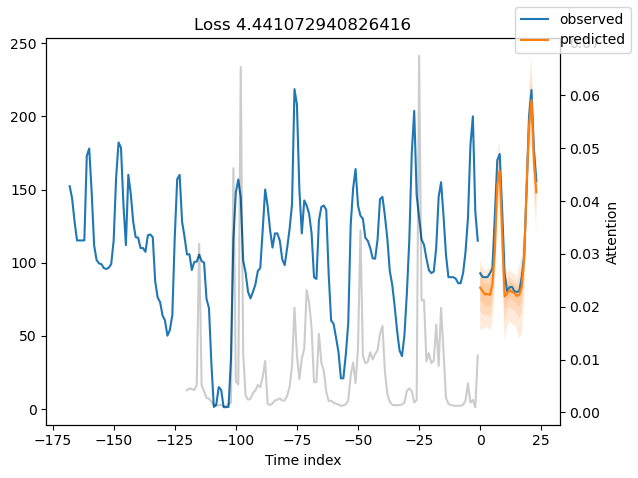

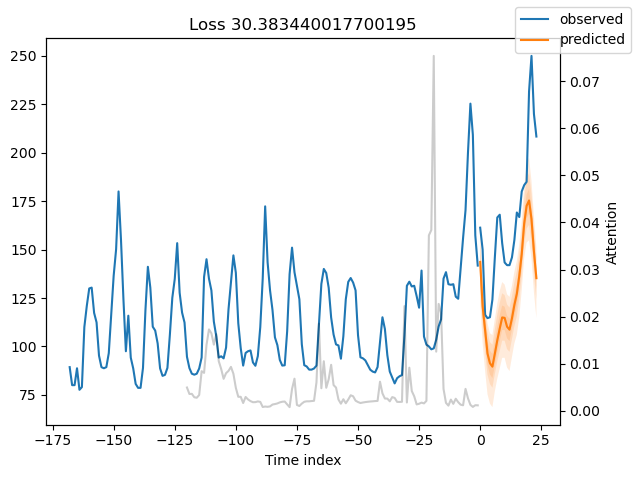

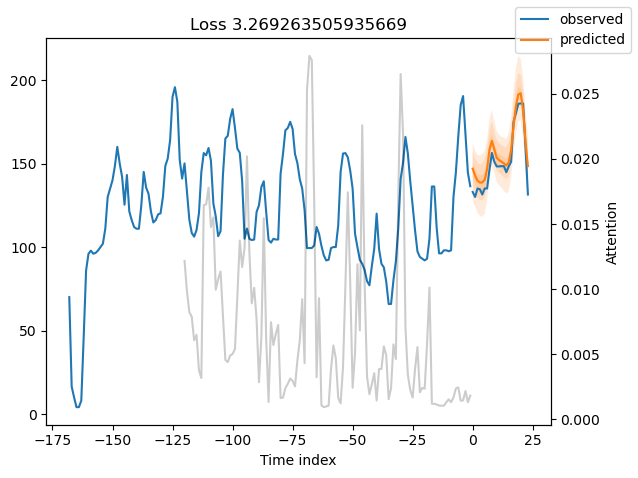

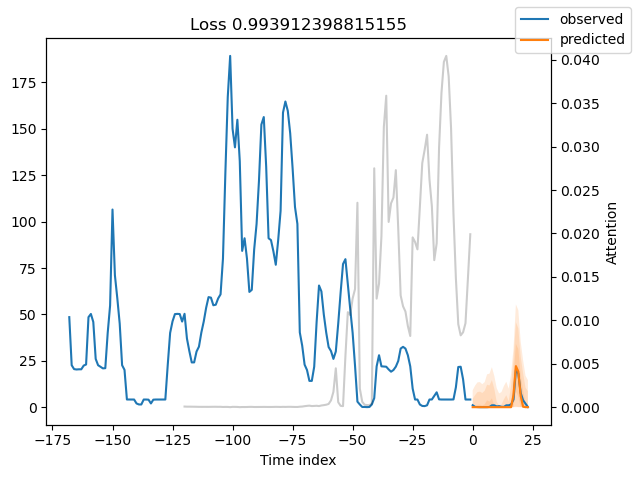

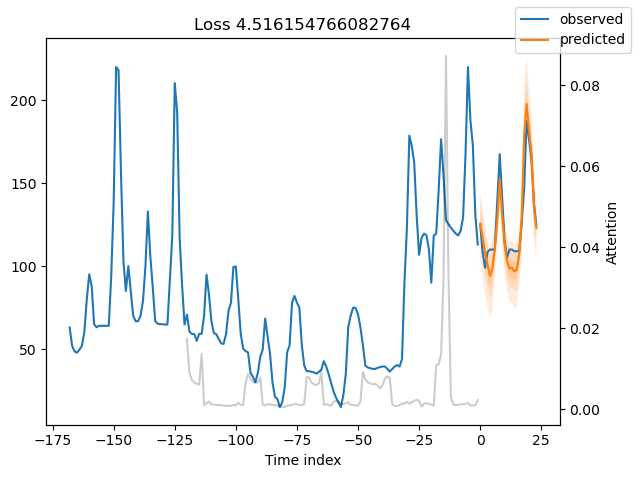

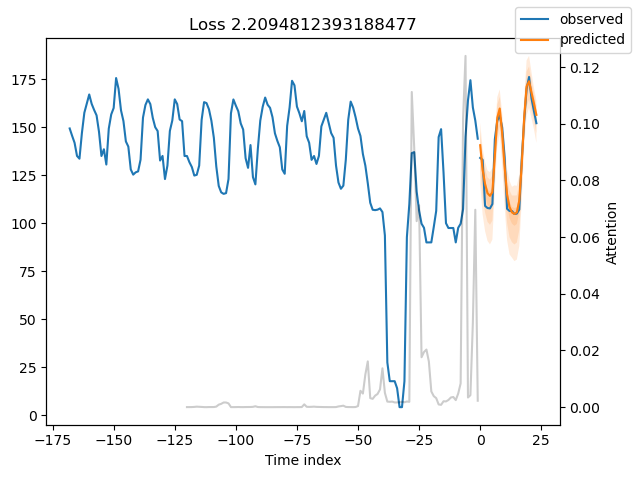

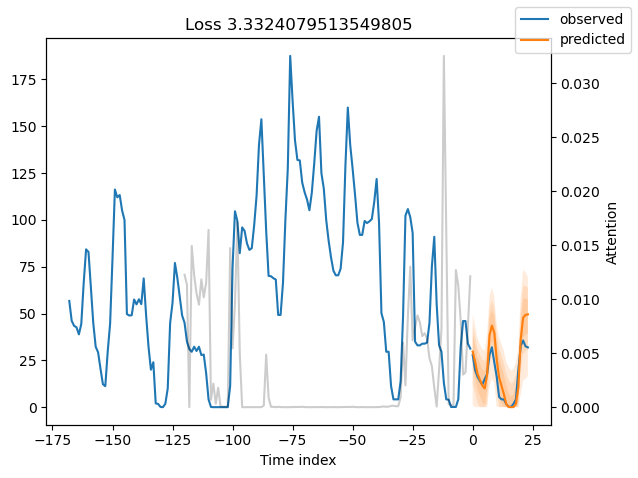

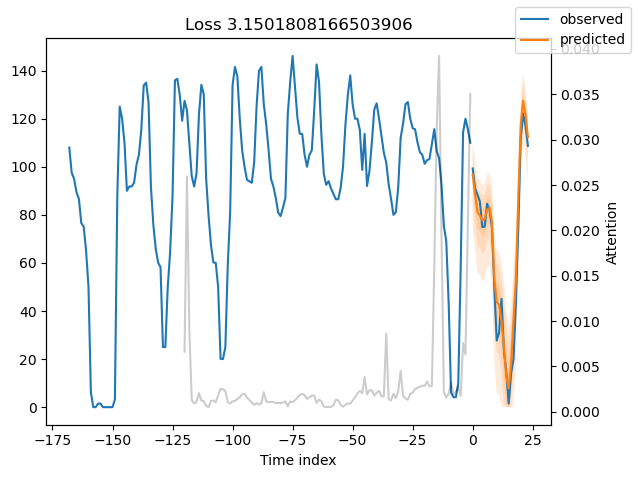

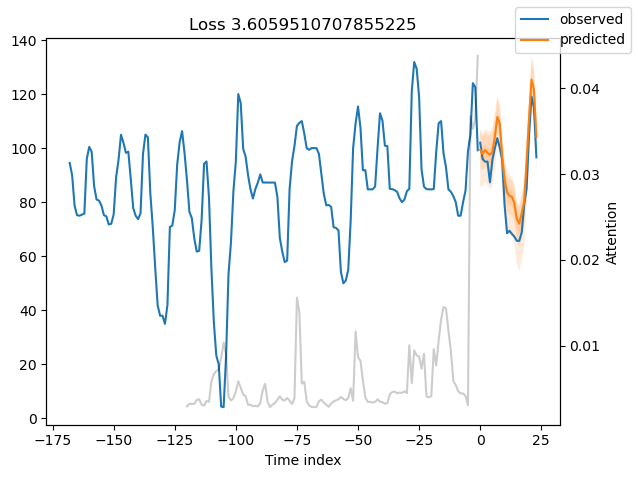

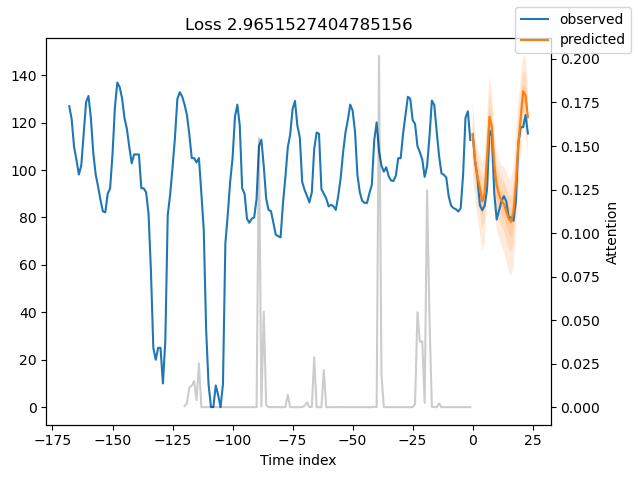

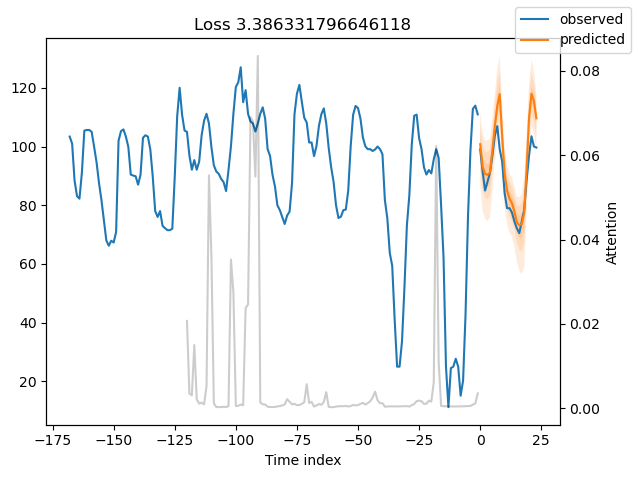

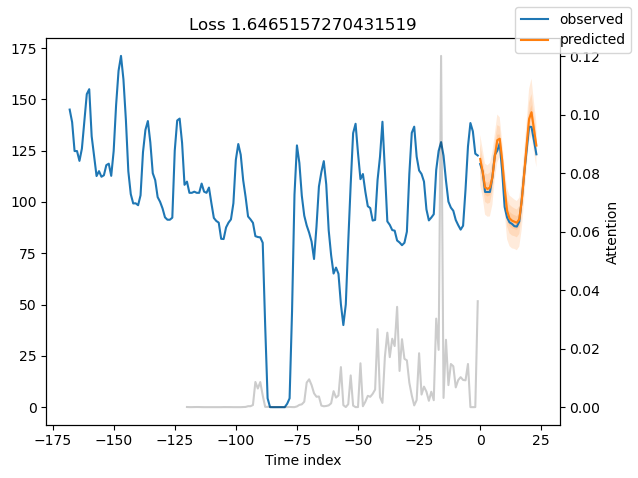

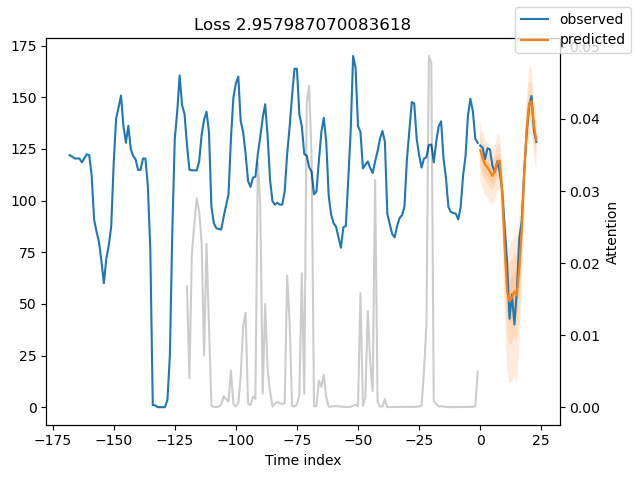

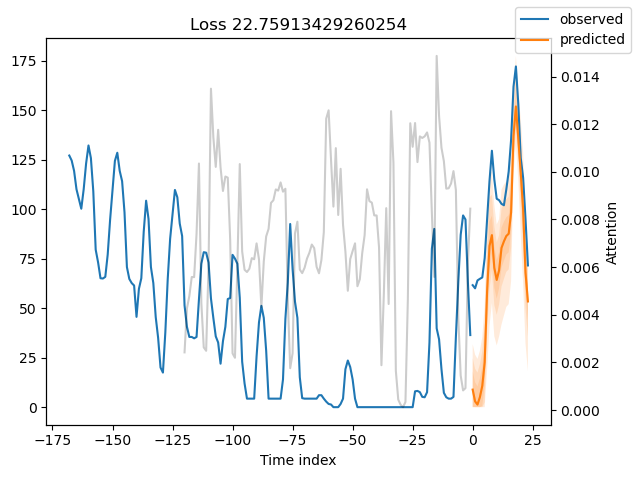

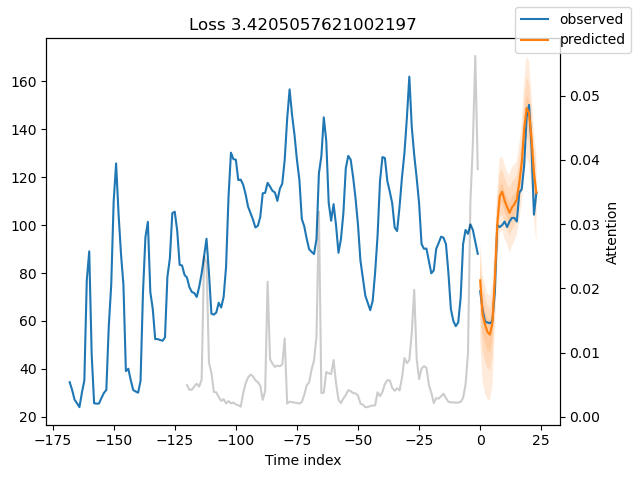

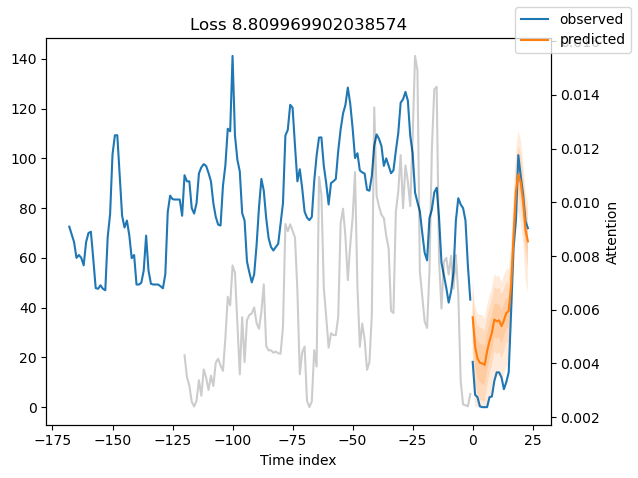

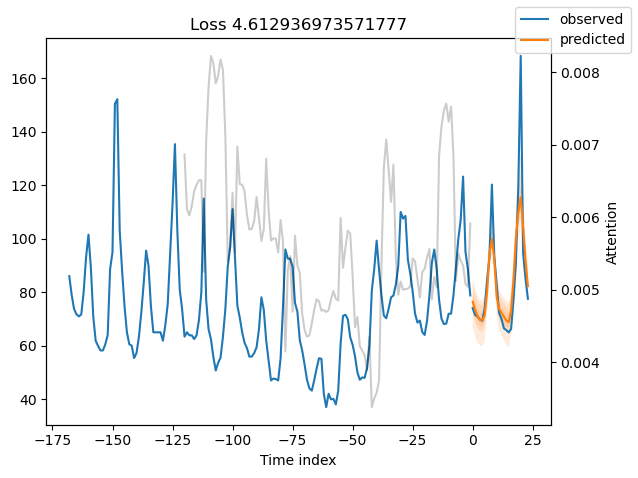

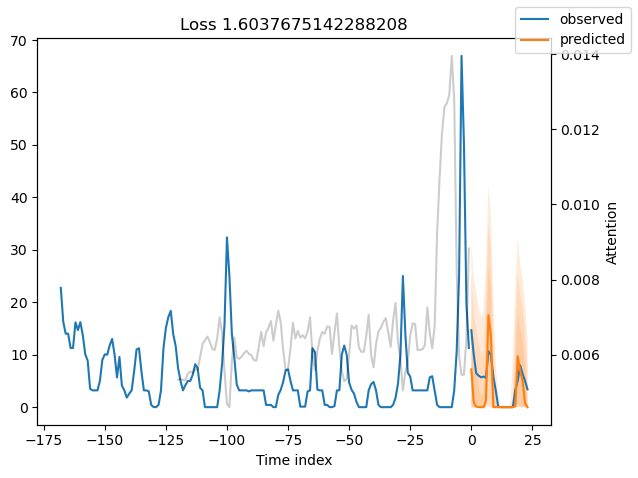

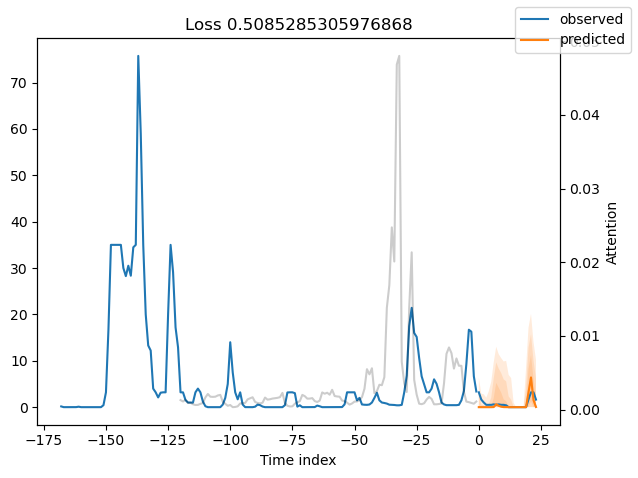

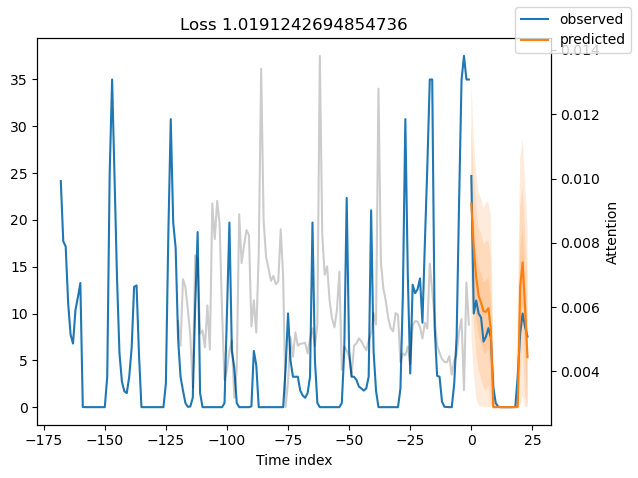

In [ ]:
if not grid_search:
    tft_predict(tft, val_dataloader)


## GRID SEARCH

In [ ]:
if grid_search:
    study, best_tft = run_hyperparameter_optimization(train, train_dataloader, val_dataloader, n_trials=50, max_epochs=30, **hyperparams_grid)
    print(study.best_trial.params)

In [ ]:
best_hyperparameters = {'gradient_clip_val': 0.022997345678533884, 'hidden_size': 12, 'dropout': 0.2243809465682846, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.0038729048630587303}



Podemos cortar la ejecucion y reanudarla posteriormente si habilitamos las siguientes lineas.

### EVAL BEST FOUND MODEL

In [ ]:
if grid_search:
    tft_predict(best_tft, val_dataloader, n_preds=10)


# TEST EVAL

## BASIC

In [ ]:
predictions = tft.predict(test_dataloader, mode="raw", return_x=True)


NameError: name 'test_dataloader' is not defined

In [ ]:
for idx in range(predictions.output[0].shape[0]):  # plot 10 examples
    tft.plot_prediction(predictions.x, predictions.output, idx=idx, add_loss_to_title=True)

## GRID TFT

In [ ]:
predictions = grid_tft.predict(test_dataloader, mode="raw", return_x=True)


In [ ]:
for idx in range(predictions.output[0].shape[0]):  # plot 10 examples
    grid_tft.plot_prediction(predictions.x, predictions.output, idx=idx, add_loss_to_title=True)

# NEW PREDS

In [ ]:
data[lambda x: x.week > x.week.max() - max_encoder_length]

In [ ]:
encoder_data = data[lambda x: x.month > x.month.max() - max_encoder_length]

last_data = data[lambda x: x.month == x.month.max()]
# Crear un rango de fechas para el periodo de predicción con frecuencia horaria
date_range = pd.date_range(start=last_data['fechaHora'].max() + pd.DateOffset(hours=1),
                           periods=max_prediction_length, freq='H')

decoder_data = pd.DataFrame({'fechaHora': date_range})

# Concatenar los DataFrames

# # Asignar las fechas al DataFrame
# decoder_data['fechaHora'] = date_range.repeat(len(last_data))

# # Asegurarse de que el DataFrame resultante tenga las mismas columnas que last_data
# decoder_data = decoder_data[last_data.columns]
# # add time index consistent with "data"
# decoder_data["month"] = decoder_data["fechaHora"].dt.year * 12 + decoder_data["fechaHora"].dt.month
# decoder_data["month"] += encoder_data["month"].max() + 1 - decoder_data["month"].min()

# adjust additional time feature(s)
# decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
# new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_data = pd.read_excel( os.path.join(PATHS['LOCAL']['root'], 'datasets', 'new_pred_input.xlsx'))


In [ ]:
new_data['month'] = 12
new_data['week'] = 53
new_data = new_data.reset_index(drop=True)
new_data['index'] = new_data.index
new_data = new_data.fillna(method='ffill')


In [ ]:
new_data = TimeSeriesDataSet.from_dataset(training, new_data, predict=True)
raw_predictions = tft.predict(new_data, mode="raw", return_index=True, return_x=True)

In [ ]:
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)

In [ ]:
prediction = []
prediction_set = 3
for i in range(raw_predictions.output.prediction[0].shape[0]):
    prediction.append(float(raw_predictions.output.prediction[0][i][prediction_set]))

In [ ]:
predictions_df = pd.DataFrame(prediction)
predictions_df.to_excel('pred2.xlsx', index=False)

In [ ]:
predictions = raw_predictions.output.prediction[0]

plt.figure(figsize=(10, 6))

for i in range(predictions.shape[1]):  
    plt.plot(predictions[:, i], label=f"Serie {i+1}")

plt.xlabel("Paso de tiempo")
plt.ylabel("Valor predicho")
plt.title("Predicciones para las 7 series temporales")
plt.legend()  
plt.show()
